In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [6]:
try:
    df_contacts = pd.read_csv("data/contacts.csv")
except:
    df_contacts = pd.read_csv("demo/data/contacts.csv")


In [7]:
formation_name = 'G'
formation = df_contacts[df_contacts['Formation'] == formation_name]
formation = formation.dropna() # Drop rows with missing values

# Get data points
x, y = formation.X_L93.values, formation.Y_L93.values
data_pts = np.column_stack((x,y))
# get elevation at data points 
data = formation.Zt.values 

print(f"Selected formation : {formation_name}\n"
      f"Min and max values of the data for formation {formation_name} : {data.min()}, {data.max()} m.")

Selected formation : G
Min and max values of the data for formation G : -40.2, 330.0 m.


# Compute experimental variogram

In [8]:
from krigeo import variogram

In [9]:
lag, var = np.asarray(variogram(data_pts, values=data, lag_max=15_000, nbins=10))

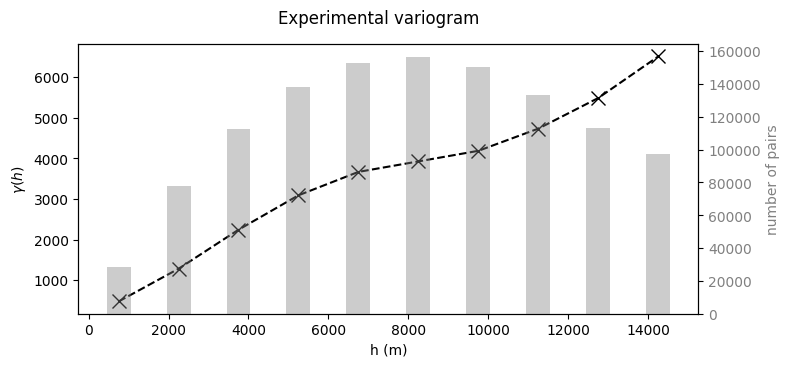

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,3.5))
ax.plot(lag, var, marker='x', markersize=10, color='k', linestyle='dashed')
ax.set_ylabel(r"$\gamma(h)$")

ax2 = ax.twinx()
ax2.bar(lag, var, width=15000/25, color='grey', alpha=0.4)
ax2.set_ylabel("number of pairs", color='grey')
ax2.tick_params(axis='y', labelcolor='grey')

ax.set_xlabel("h (m)")
plt.suptitle("Experimental variogram")
plt.show()

# Automatically fit variogram models

In [11]:
from krigeo import covariance_models, fit_covariance_model

Fit the four available models to the experimental variogram

The initial model must be set with parameters within an approximate 'good' range, so that the fitting algorithm can converge.

In [12]:
cov = covariance_models["spherical"](sill=5_000, range=5_000)
cov, cov_mse = cov.fit(data_pts, lag_max=10_000, nbins=10, values=data)

cov_exp = covariance_models["exponential"](sill=5_000, range=5_000)
cov_exp, cov_exp_mse = cov_exp.fit(data_pts, lag_max=10_000, nbins=10, values=data)

cov_gaus = covariance_models["gaussian"](sill=5_000, range=5_000)
cov_gaus, cov_gaus_mse = cov_gaus.fit(data_pts, lag_max=10_000, nbins=10, values=data)

cov_cubic = covariance_models["cubic"](sill=5_000, range=5_000)
cov_cubic, cov_cubic_mse = cov_cubic.fit(data_pts, lag_max=10_000, nbins=10, values=data)

Plot the fitted models

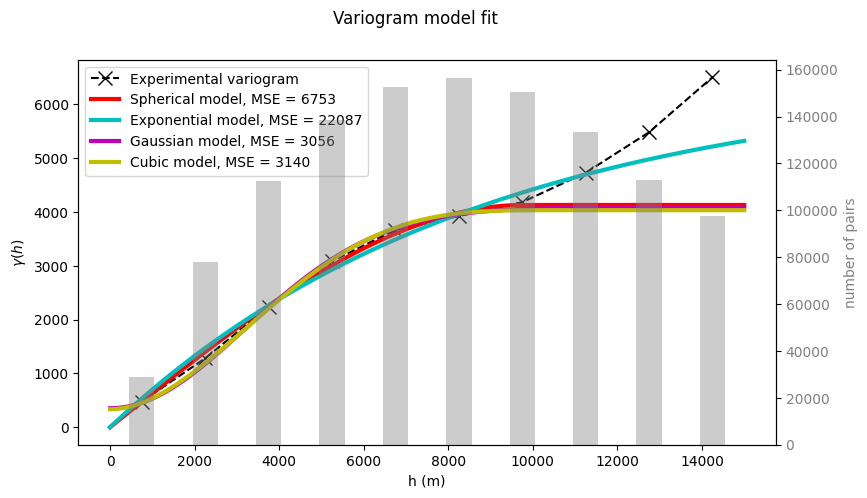

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
ax.plot(lag, var, marker='x', markersize=10, color='k', linestyle='dashed', label="Experimental variogram")
ax.set_ylabel(r"$\gamma(h)$")

x_plot = np.linspace(0, 15000, 500)
ax.plot(x_plot, cov(x_plot), color='r', label=f"Spherical model, MSE = {cov_mse:4.0f}", linewidth=3)
ax.plot(x_plot, cov_exp(x_plot), color='c', label=f"Exponential model, MSE = {cov_exp_mse:4.0f}", linewidth=3)
ax.plot(x_plot, cov_gaus(x_plot), color='m', label=f"Gaussian model, MSE = {cov_gaus_mse:4.0f}", linewidth=3)
ax.plot(x_plot, cov_cubic(x_plot), color='y', label=f"Cubic model, MSE = {cov_cubic_mse:4.0f}", linewidth=3)
plt.legend()
ax2 = ax.twinx()
ax2.bar(lag, var, width=15000/25, color='grey', alpha=0.4, zorder=0)
ax2.set_ylabel("number of pairs", color='grey')
ax2.tick_params(axis='y', labelcolor='grey')

ax.set_xlabel("h (m)")
plt.suptitle("Variogram model fit")
plt.show()

The best model in this case is the gaussian model, with Mean Square Error of 3056. This is the model that would be chosen by the "auto" mode of the fit function, as it is done below.

In [17]:
auto_cov = fit_covariance_model(data_pts, lag_max=10_000, nbins=10, values=data, model="auto")

In [18]:
print(f"Fitted parameters for auto model are :\n"
      f"  - type : {auto_cov.__class__.__name__}\n"
      f"  - range : {auto_cov.range:4.0f}\n"
      f"  - sill : {auto_cov.sill:4.0f}\n"
      f"  - nugget : {auto_cov.nugget:4.0f}\n")

Fitted parameters for auto model are :
  - type : GaussianCovariance
  - range : 4836
  - sill : 3738
  - nugget :  352

